In [1]:
install.packages("raster")
install.packages("RItools")

Warning message in install.packages("raster"):
“installation of package ‘raster’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#!/usr/bin/env Rscript

# This global processing script PART II is derived from the global processing notebook 
#the input can be the iso3 code (3-character) for one or multiple countries 

#mamba install -c conda-forge r-terra r-optmatch r-sp r-rgdal r-sf r-rgeos r-dplyr r-plyr r-ggplot2 r-raster r-mapview r-stringr r-maptools r-gridExtra r-lattice r-MASS r-foreach r-doParallel r-rlang r-tidyr r-magrittr r-viridis r-ggmap r-Hmisc r-hrbrthemes r-spatialEco r-bit64 r-randomForest r-modelr r-ranger r-caret r-rgeos r-ritools

options(warn=-1)
options(dplyr.summarise.inform = FALSE)

packages <- c("sp","rgdal","sf","rgeos","dplyr","plyr","ggplot2","raster","mapview","stringr",
              "maptools","gridExtra","lattice","MASS","foreach","optmatch","doParallel","RItools","gdalUtils",
              "rlang","tidyr","magrittr","viridis","ggmap","Hmisc","hrbrthemes","spatialEco","bit64","randomForest", "modelr","ranger","caret")
package.check <- lapply(packages, FUN = function(x) {
  suppressPackageStartupMessages(library(x, character.only = TRUE))
})

args = commandArgs(trailingOnly=TRUE)
if (length(args)==0) {
  stop("At least one argument must be supplied (input file).n", call.=FALSE)
} else if (length(args)>=1) {
  
  iso3 <- args[1]  #country to process
  gediwk <- args[2]   #the # of weeks GEDI data to use
  mproc <- as.integer(args[3])#the number of cores to use for macthing 
}

In [38]:
#Get Info for GPKG Table Name
ogrInfo("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg")

Source: "/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg", layer: "SEN_admin_L2A"
Driver: GPKG; number of rows: 12774217 
Feature type: wkbPoint with 2 dimensions
Extent: (-17.52855 12.30903) - (-11.34619 16.69272)
CRS: +proj=longlat +datum=WGS84 +no_defs 
Number of fields: 10 
                         name type length  typeName
1                    filename    4      0    String
2                        rh50    2      0      Real
3                        rh25    2      0      Real
4                        rh98    2      0      Real
5              lon_lowestmode    2      0      Real
6                        rh90    2      0      Real
7                 shot_number   12      0 Integer64
8  geolocation/sensitivity_a2    2      0      Real
9              lat_lowestmode    2      0      Real
10                       rh75    2      0      Real

In [70]:
# Subset GEDI data to first 3 features for running troubleshooting
#Run only once!
# sf<- st_read("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg",query = "select * from SEN_admin_L2A limit 3;")
# print(sf)
# st_write(sf,"~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_L2A_subset.gpkg")

In [61]:
iso3 <- "SEN"
gediwk<-24
mproc <-1

cat("Step 0: Loading global variables to process country", iso3,"with GEDI data until week", gediwk, "\n")

f.path <- cat("~/GEDI_PA/Matching_Layers/SEN/")
ecoreg_key <- read.csv(paste("~/GEDI_PA/wwf_ecoregions_key.csv",sep=""))
allPAs <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_PA_poly.rds",sep=""))
MCD12Q1 <- raster(paste("~/GEDI_PA/GEDI_ANCI_PFT_r1000m_EASE2.0_UMD_v1_projection_defined_6933.tif",sep=""))
projection(MCD12Q1) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
world_region <- raster(paste("~/GEDI_PA/GEDI_ANCI_CONTINENT_r1000m_EASE2.0_UMD_v1_revised_projection_defined_6933.tif",sep=""))
projection(world_region) <- sp::CRS(paste("+init=epsg:",6933,sep=""))
adm <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/SEN_admin.geojson"),verbose=FALSE)
adm_prj <- spTransform(adm, "+init=epsg:6933") 
load("~/GEDI_PA/rf_noclimate.rdata")
source("~/GEDI_PA/matching_func.r") #WILL NEED TO CHANGE FOR FULL GEDI DATASET IN FUTURE
# flag <- "don't ran extraction"
flag <- "run all"
# flag <- "run remaining"

Step 0: Loading global variables to process country SEN with GEDI data until week 24 
~/GEDI_PA/Matching_Layers/SEN/

In [57]:
#Subset GEDI to tiles FOR TESTING
tile<- st_read("~/GEDI_PA/Matching_Layers/SEN/SampleTile_4.geojson")
# spatial filter, as wkt:
wkt = st_as_text(st_geometry(tile[1,]))
print(wkt)
# sf<- st_read("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l4a_clean_SEN/SEN_admin_L4A.gpkg", wkt_filter = wkt)
# st_write(sf,"~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l4a_clean_SEN/SEN_L4A_subset_Til1.gpkg")

Reading layer `SampleTile_4' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/SampleTile_4.geojson' 
  using driver `GeoJSON'
Simple feature collection with 4 features and 2 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -17 ymin: 12 xmax: -15 ymax: 14
Geodetic CRS:  WGS 84
[1] "POLYGON ((-17 12, -16 12, -16 13, -17 13, -17 12))"


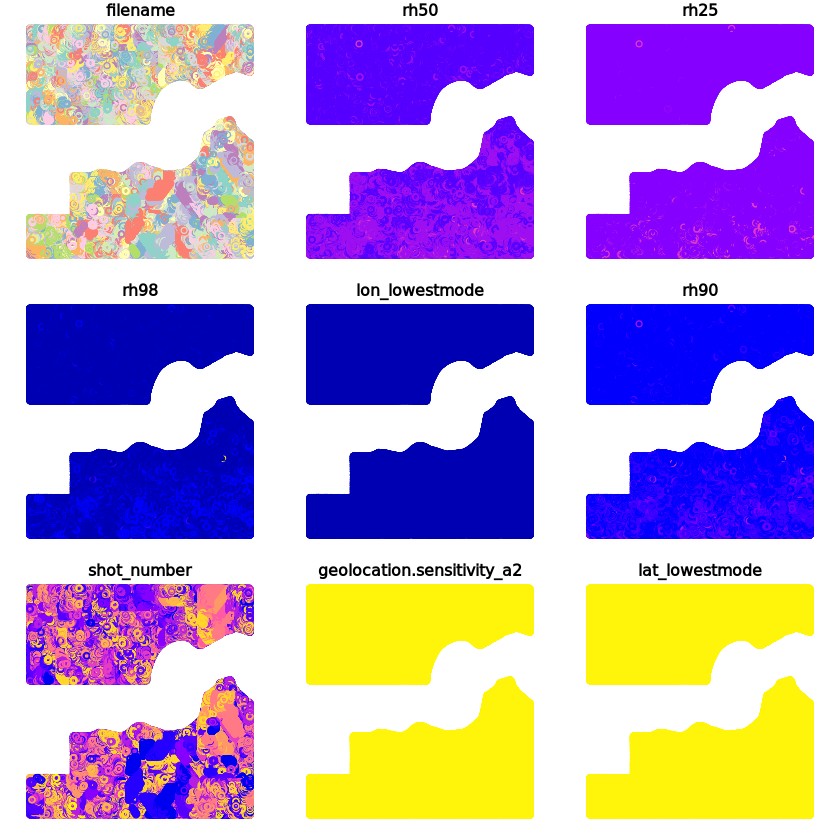

In [166]:
plot(sf)

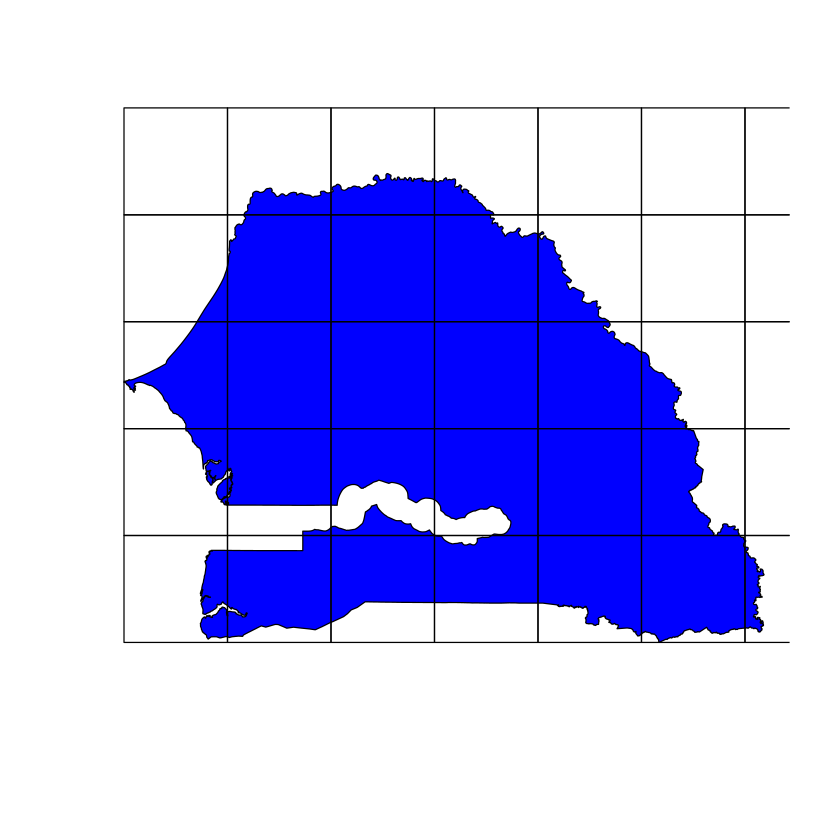

In [179]:
grd <- data.frame(sf::st_make_grid(adm, cellsize = 1))
plot(adm, col = "blue")
plot(grd, add = TRUE)

In [240]:
setwd('/projects/GEDI_PA')

In [242]:
grd$ID <- seq.int(nrow(grd))

grd<-st_read(grd)
unique <- unique(grd$ID)

for (i in 1:length(unique)) {
  tmp <- grd[grd$ID == unique[i], ]
    st_write(tmp,dsn="GEDI_PA/Matching_Layers/SEN/SEN_Tiles/",unique[i],".gpkg",,sep="")
  # writeOGR(tmp, dsn="~/GEDI_PA/Matching_Layers/SEN/SEN_Tiles", unique[i], driver="GeoJSON",
  #          overwrite_layer=TRUE)
}

ERROR: Error in if (nchar(dsn) < 1) stop("`dsn` must point to a source, not an empty string.", : the condition has length > 1


In [64]:
#---------------STEP5. GEDI PROCESSING - using GEDI shots to extract the treatment/control status, also extract the MODIS PFT for AGB prediction---------------- 
# if (file.exists(paste(f.path,"WDPA_GEDI_extract/",iso3,"_wk",gediwk,"/",iso3,"_gedi_extracted_matching_wk",gediwk,".RDS", sep=""))){
cat(paste("Step 5: Performing WK ",gediwk,"GEDI extraction for", iso3,"\n"))
#matched_all <-read.csv(paste(f.path,"WDPA_extract4_residual_PAs/", iso3, "_wk_", gediwk, "_null_matches_rerun.csv",sep="")) 
matched_all<-list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
# readr::parse_number() %>% unique()
#list.files(paste(f.path,"WDPA_matching_results/",iso3,"_wk",gediwk,sep=""), pattern=".RDS", full.names = FALSE)
registerDoParallel(3)
matched_PAs <- foreach(this_rds=matched_all, .combine = c, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {   #non-NA matched results
  matched_PAs=c()
  print(this_rds)
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
  if(!is.null(matched)){
    if(nrow(matched)!=0){
      matched_PAs=c(matched_PAs,this_rds) 
    }
  }else {
    # print(this_rds)
    matched_PAs=matched_PAs
  }
  return(matched_PAs)
}
stopImplicitCluster()

Step 5: Performing WK  24 GEDI extraction for SEN 


In [65]:
if(flag=="run all"){  #determine how many PAs to run the extraction process
  matched_PAs <- matched_PAs
  cat("Step 5: runing extraction on all", length(matched_PAs),"of non-NA matched results in", iso3,"\n")
} else if (flag=="run remaining"){
  pattern1 = c(paste("wk",gediwk,sep=""),"RDS")
  extracted_PAid <- list.files(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep=""), full.names = F, pattern=paste0(pattern1, collapse="|"))%>%
    readr::parse_number() %>% unique()
  matched_PA_id <- matched_PAs %>% readr::parse_number()
  runPA_id <- matched_PA_id[!(matched_PA_id %in% extracted_PAid)]
  if (length(runPA_id)>0){
    Pattern2 <-  paste(runPA_id, collapse="|")
    runPA <-  matched_PAs[grepl(Pattern2,matched_PAs)]
    # runPA_ind <- str_detect(matched_PAs, paste(runPA_id, collapse = "|"))
    matched_PAs <-runPA
  } else {
    matched_PAs <- NULL
    cat("Step 5 already done for", iso3, "\n")
  }
}

Step 5: runing extraction on all 108 of non-NA matched results in SEN 


In [66]:
registerDoParallel(cores=round(mproc))
getDoParWorkers()
startTime <- Sys.time()

[1] 1

In [67]:
print(matched)

# A tibble: 15,116 × 21
     lat   lon   UID status land_cover wwfbiom         wwfecoreg elevation slope
   <dbl> <dbl> <int> <lgl>  <fct>      <fct>           <fct>         <dbl> <dbl>
 1  13.0 -13.5    45 TRUE   l1_forest  Tropical & Sub… West Sud…        35 0.658
 2  12.7 -13.3   141 TRUE   l1_forest  Tropical & Sub… Guinean …        62 1.43 
 3  12.9 -13.4   157 TRUE   l1_forest  Tropical & Sub… Guinean …        49 0.613
 4  13.1 -13.5   171 TRUE   l1_forest  Tropical & Sub… West Sud…        20 0.163
 5  12.7 -13.3   178 TRUE   l1_forest  Tropical & Sub… Guinean …        86 1.29 
 6  13.0 -13.5   215 TRUE   l1_forest  Tropical & Sub… West Sud…        19 0.176
 7  12.8 -13.4   240 TRUE   l1_forest  Tropical & Sub… Guinean …        70 0.744
 8  12.7 -13.3   268 TRUE   l1_forest  Tropical & Sub… Guinean …       120 0.812
 9  12.8 -13.4   280 TRUE   l1_forest  Tropical & Sub… Guinean …        47 0.470
10  12.7 -13.3   315 TRUE   l1_forest  Tropical & Sub… Guinean …        95 0.835
# ℹ 

In [75]:
#FOR FULL DATASET
# foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
#   cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
#   if(nchar(iso3)>3){
#     id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
#   } else {
#     id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
#   }
#   matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", id_pa,"_matching_results_wk",gediwk,".RDS", sep=""))
#   if (is.null(matched)==TRUE  | nrow(matched)==0) {
#     cat("Matched result is null for PA", id_pa, "quitting...\n")
#   } else if (!is.null(matched)==TRUE){
#     mras  <- tryCatch(matched2ras(matched),
#                       error=function(cond){
#                         message(cond)
#                         cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
#                         # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
#                         return(NULL)}) #convert the macthed df to a raster stack 
#     if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
#       cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
#     } else {
#       startTime <- Sys.time()
#       iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)  #run filtered csvs on mras for extarction
#       tElapsed <- Sys.time()-startTime
#     iso_matched_gedi<- matched
#       cat(tElapsed, "for extracting all PAs in", iso3,"\n")
#       iso_matched_gedi_sub <- iso_matched_gedi %>%
#         #ASK AMBER ABOUT OG COLUMNS
#         dplyr::select("pa_id","status","wwfbiom","wwfecoreg","lon_lowestmode","lat_lowestmode",
#                       "rh_010","rh_020", "rh_030", "rh_040",  "rh_050",  "rh_060" , "rh_070","rh_075",  "rh_080",  "rh_090",  "rh_098", "AGBD","cover","pai","REGION","PFT")  #write to individual country folder
#       if (length(unique(iso_matched_gedi$wwfbiom)) >1){
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
#       } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
#       } else {
#         pabiome <- iso_matched_gedi$wwfbiom %>% unique()
#       }
#       # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
#       continent <- unique(iso_matched_gedi$region) %>% getmode()

#       dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
#       saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
#       cat(id_pa,"in",iso3,"results is written to dir\n")
#       write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
#     }
#   }
#   return(NULL)
# }

# stopImplicitCluster()
# tElapsed <- Sys.time()-startTime
# cat(tElapsed, "for extracting all PAs in", iso3,"\n")
# cat("Done GEDI extraction for pa in ",iso3,"\n")    

In [77]:
# TESTING FOR SING RDS

foreach(this_rds=matched_PAs, .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
  cat("Extracting for no. ", match(this_rds,matched_PAs),"pa out of", length(matched_PAs),"\n")
  if(nchar(iso3)>3){
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[4]  
  } else {
    id_pa <- this_rds %>% str_split("_") %>% unlist %>% .[3]
  }
  matched <- readRDS(paste("GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/SEN_wk24/SEN_pa_2332_matching_results_wk24.RDS", sep=""))
  if (is.null(matched)==TRUE  | nrow(matched)==0) {
    cat("Matched result is null for PA", id_pa, "quitting...\n")
  } else if (!is.null(matched)==TRUE){
    mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 
    if(table(mras$status[])[2]==0 | table(mras$status[])[1]==0 | is.null(mras)){
      cat("Rasterized results unbalanced for PA", id_pa, "quitting...\n")
    } else {
      startTime <- Sys.time()
      iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)  #run filtered csvs on mras for extarction
      tElapsed <- Sys.time()-startTime
    iso_matched_gedi<- matched
      cat(tElapsed, "for extracting all PAs in", iso3,"\n")
      iso_matched_gedi_sub <- iso_matched_gedi %>%
        #ASK AMBER ABOUT OG COLUMNS
        dplyr::select("pa_id","status","wwfbiom","wwfecoreg","lon_lowestmode","lat_lowestmode",
                      "rh_010","rh_020", "rh_030", "rh_040",  "rh_050",  "rh_060" , "rh_070","rh_075",  "rh_080",  "rh_090",  "rh_098", "AGBD","cover","pai","REGION","PFT")  #write to individual country folder
      if (length(unique(iso_matched_gedi$wwfbiom)) >1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)%>% str_c( collapse = "+")
      } else if (length(unique(iso_matched_gedi$wwfbiom))==1){
        pabiome <- iso_matched_gedi$wwfbiom %>% unique() %>% gsub('\\b(\\pL)\\pL{2,}|.','\\U\\1',.,perl = TRUE)
      } else {
        pabiome <- iso_matched_gedi$wwfbiom %>% unique()
      }
      # papaddd <- unique(iso_matched_gedi$PADDD) %>% getmode()
      continent <- unique(iso_matched_gedi$region) %>% getmode()

      dir.create(file.path(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/",iso3,"_wk",gediwk,"/",sep="")))
      saveRDS(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/",iso3,"_pa_", id_pa,"_gedi_wk_",gediwk,"_conti_","biome_",pabiome,".RDS", sep=""))
      cat(id_pa,"in",iso3,"results is written to dir\n")
      write.csv(iso_matched_gedi, file=paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_GEDI_extract4/SEN_wk24/","SEN_pa_", id_pa,"_iso_matched_gedi_sub_wk_",gediwk,".csv", sep=""))
    }
  }
  return(NULL)
}

stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

Extracting for no.  1 pa out of 108 
Extracting for no.  2 pa out of 108 
Extracting for no.  3 pa out of 108 
Extracting for no.  4 pa out of 108 
Extracting for no.  5 pa out of 108 
Extracting for no.  6 pa out of 108 
Extracting for no.  7 pa out of 108 
Extracting for no.  8 pa out of 108 
Extracting for no.  9 pa out of 108 
Extracting for no.  10 pa out of 108 
Extracting for no.  11 pa out of 108 
Extracting for no.  12 pa out of 108 
Extracting for no.  13 pa out of 108 
Extracting for no.  14 pa out of 108 
Extracting for no.  15 pa out of 108 
Extracting for no.  16 pa out of 108 
Extracting for no.  17 pa out of 108 
Extracting for no.  18 pa out of 108 
Extracting for no.  19 pa out of 108 
Extracting for no.  20 pa out of 108 
Extracting for no.  21 pa out of 108 
Extracting for no.  22 pa out of 108 
Extracting for no.  23 pa out of 108 
Extracting for no.  24 pa out of 108 
Extracting for no.  25 pa out of 108 
Extracting for no.  26 pa out of 108 
Extracting for no.  2

ERROR: Error in {: task 1 failed - "cannot open the connection"


In [31]:
stopImplicitCluster()
tElapsed <- Sys.time()-startTime
cat(tElapsed, "for extracting all PAs in", iso3,"\n")
cat("Done GEDI extraction for pa in ",iso3,"\n")    

1.109392 for extracting all PAs in SEN 
Done GEDI extraction for pa in  SEN 


### below is testing how to extract the GEDI data for one PA's matching results 5/16

In [44]:
matched <- readRDS(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_matching_points/",iso3,"_wk",gediwk,"/",iso3,"_pa_", "2332","_matching_results_wk",gediwk,".RDS", sep=""))
print(matched)

# A tibble: 12,806 × 21
     lat   lon   UID status land_cover     wwfbiom    wwfecoreg elevation  slope
   <dbl> <dbl> <int> <lgl>  <fct>          <fct>      <fct>         <dbl>  <dbl>
 1  14.6 -13.8    35 TRUE   l2_grassland   Tropical … West Sud…        52 0.428 
 2  14.7 -13.7   120 TRUE   l3_agriculture Tropical … West Sud…        46 0.312 
 3  14.9 -13.6   131 TRUE   l2_grassland   Tropical … West Sud…        69 0.0386
 4  14.5 -13.9   143 TRUE   l2_grassland   Tropical … West Sud…        56 0.0556
 5  14.5 -13.8   150 TRUE   l2_grassland   Tropical … West Sud…        59 0.0556
 6  14.9 -13.5   183 TRUE   l2_grassland   Tropical … Sahelian…        63 0.143 
 7  14.7 -13.7   204 TRUE   l2_grassland   Tropical … West Sud…        60 0.309 
 8  14.5 -13.9   228 TRUE   l2_grassland   Tropical … West Sud…        57 0.0556
 9  14.6 -13.8   236 TRUE   l2_grassland   Tropical … West Sud…        54 0.278 
10  14.9 -13.5   268 TRUE   l2_grassland   Tropical … Sahelian…        67 0.143 
# ℹ 

In [45]:
mras  <- tryCatch(matched2ras(matched),
                      error=function(cond){
                        message(cond)
                        cat("Matched result is likely null for country", iso3,"pa", id_pa, "dimension of the match is", dim(matched),"\n")
                        # writeLines("Matched results is likely null for country", paste(f.path,"WDPA_log/",iso3,"_log_matching.txt", sep=""))
                        return(NULL)}) #convert the macthed df to a raster stack 

SEN converting the matched csv to a raster stack for extraction


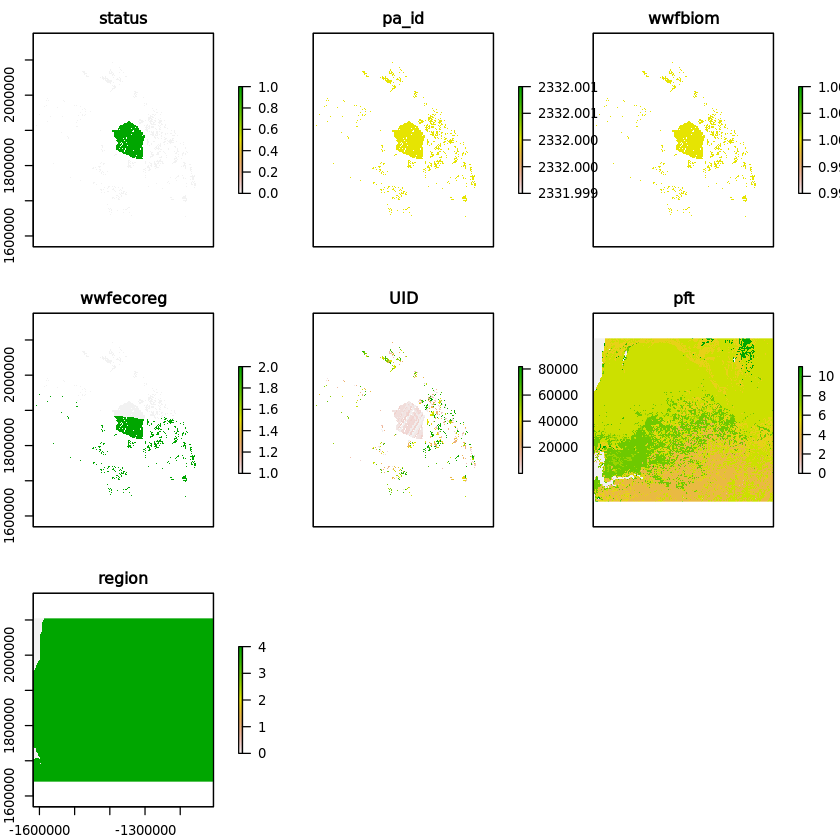

In [83]:
plot(mras)


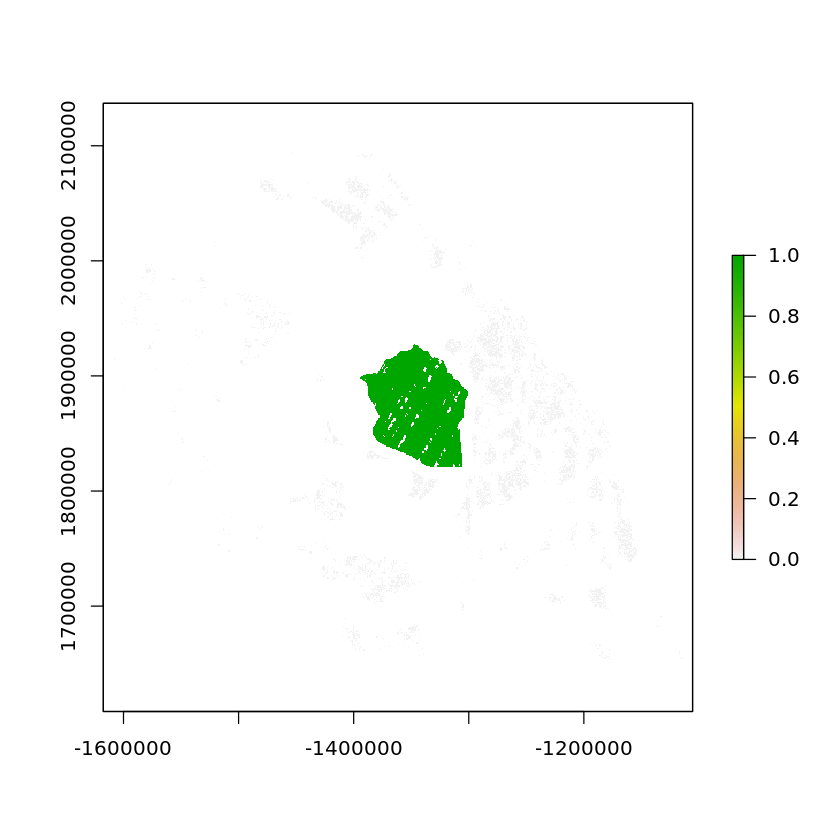

In [72]:
plot(mras$status)
plot(tile, add = TRUE)

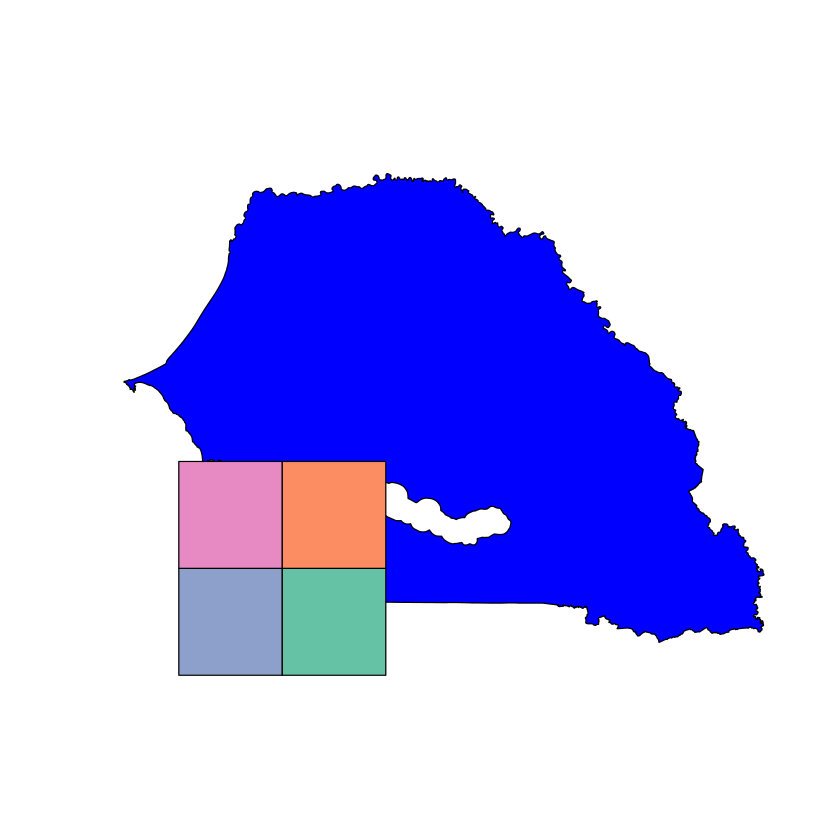

In [65]:
plot(adm, col = "blue")
plot(tile, add = TRUE)

In [90]:
# essentially we want to extract gedi shots over the raster grids, but the extract_gedi function needs customization [done below]
# iso_matched_gedi<- extract_gedi(matched=matched, mras = mras)

## this is re-writing the extract_gedi() function 

In [ ]:
extract_gedi <- function(matched, mras){
    f.path <- '~/GEDI_PA/Matching_Layers/SEN/'
    all_gedil2_f <- list.files(file.path(f.path,"WDPA_gedi_l2a+l2b_clean2_SEN"), full.names = TRUE, pattern = '.gpkg') 
    all_gedil4_f <- list.files(file.path(f.path,"WDPA_gedi_l4a_clean_SEN"), full.names = TRUE, pattern ='.gpkg') 
    
    registerDoParallel(cores=round(mproc*0.5))
    ex_out <- foreach(this_csvid=seq(length(all_gedil2_f)), 
                  .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(all_gedil2_f),"csvs for iso3",iso3,"\n")
        gedi_l2  <- st_read(all_gedil2_f[this_csvid]) %>%as.data.frame()%>%
            dplyr::select(shot_number,lon_lowestmode, lat_lowestmode,rh25, rh50, rh75,rh90, rh98)

        gedi_l4  <- st_read(all_gedil4_f[this_csvid]) %>% as.data.frame()
        if (nrow(gedi_l4) < 1){   #is.na(gedi_l4) || 
          cat("error")
          gedi_l24 <- gedi_l2
          gedi_l24$agbd <- NA
          gedi_l24$agbd_se <- NA
          gedi_l24$agbd_t <- NA
          gedi_l24$agbd_t_se <- NA
        } else {
          gedi_l4_sub <- gedi_l4 %>%
            dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
          gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")

        }

        print(dim(gedi_l24))
        iso_matched_gedi_df <- data.frame()
        if(nrow(gedi_l24)>0){
            gedi_l24_sp <- gedi_l24 %>% 
                SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
                                     proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

            matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
            matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
            matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
              convertFactor(matched0 = matched,exgedi = .) 

            iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
            print(paste('extracted shots',dim(iso_matched_gedi_df), sep=' '))
        }

        return(iso_matched_gedi_df)

    }
    stopImplicitCluster()
    cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
    return(ex_out)
    
}

Readng in no.  1 csv of  4 csvs for iso3 SEN 
Reading layer `SEN_L2A_subset_Til1' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_L2A_subset_Til1.gpkg' 
  using driver `GPKG'
Simple feature collection with 334823 features and 10 fields (with 1 geometry empty)
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.7912 ymin: 12.33928 xmax: -16 ymax: 13
Geodetic CRS:  WGS 84
Reading layer `SEN_L4A_subset_Til1' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l4a_clean_SEN/SEN_L4A_subset_Til1.gpkg' 
  using driver `GPKG'
Simple feature collection with 110918 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.79026 ymin: 12.33969 xmax: -16 ymax: 12.99999
Geodetic CRS:  WGS 84
[1] 1693513      12
[1]  0 21
Readng in no.  2 csv of  4 csvs for iso3 SEN 
Reading layer `SEN_L2A_subset_Til2' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_L2A_su

In [54]:
ex_out%>%dim()
ex_out$status%>%table()

[1] 13231    21

.
    0 
13231 

### here we dive into the extract_gedi function, but will work around the old GEDI product structure, to use the MAAP-derived verions

In [93]:
all_gedil2_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_L2A_Sub/SEN_L2A_subset.gpkg')  #testing with one subset of l2a
print(dim(all_gedil2_f))
print(class(all_gedil2_f))

Reading layer `SEN_L2A_subset' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/SEN_L2A_Sub/SEN_L2A_subset.gpkg' 
  using driver `GPKG'
Simple feature collection with 3 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -16.16459 ymin: 12.45171 xmax: -16.16365 ymax: 12.45295
Geodetic CRS:  WGS 84
[1]  3 11
[1] "sf"         "data.frame"


In [97]:
all_gedil4_f<-st_read('~/GEDI_PA/Matching_Layers/SEN/SEN_L4A_Sub/SEN_L4A_subset.gpkg')  #testing with one subset of l2b 
print(dim(all_gedil4_f))
print(class(all_gedil4_f))

Reading layer `SEN_L4A_subset' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/SEN_L4A_Sub/SEN_L4A_subset.gpkg' 
  using driver `GPKG'
Simple feature collection with 3 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -15.24591 ymin: 12.7054 xmax: -15.1853 ymax: 12.78554
Geodetic CRS:  WGS 84
[1]  3 17
[1] "sf"         "data.frame"


In [114]:
gedi_l4 <- as.data.frame(all_gedil4_f)
gedi_l2 <- as.data.frame(all_gedil2_f)
if (nrow(gedi_l4) < 1){   #is.na(gedi_l4) || 
          cat("error")
          gedi_l24 <- gedi_l2
          gedi_l24$agbd <- NA
          gedi_l24$agbd_se <- NA
          gedi_l24$agbd_t <- NA
          gedi_l24$agbd_t_se <- NA
        } else {
          gedi_l4_sub <- gedi_l4 %>%
            dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
          gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")
        
        }

In [132]:
# gedi_l24[rowSums(is.na(gedi_l24)) > 0, ]   
# gedi_l24 <- left_join(gedi_l2, gedi_l4, by="shot_number") #%>% drop_na()
print(dim(gedi_l24))
iso_matched_gedi_df <- data.frame()
if(nrow(gedi_l24)>0){
    gedi_l24_sp <- gedi_l24 %>% 
        SpatialPointsDataFrame(coords=.[,c("lon_lowestmode.x","lat_lowestmode.x")],
                             proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))

    matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
    matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
    matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
      convertFactor(matched0 = matched,exgedi = .) 

    iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
    print(dim(iso_matched_gedi_df))
}

[1]  3 27
[1]  0 36


## this is the end of the extract_gedi() function for single l2/l4 file 

In [ ]:
shape <- read_sf(read)

In [ ]:
shape

In [15]:
all_gedil2_f<-st_read(all_gedil2_f)
print(dim(all_gedil2_f))
print(class(all_gedil2_f))

Reading layer `SEN_admin_L2A' from data source 
  `/projects/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN/SEN_admin_L2A.gpkg' 
  using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 12774217 features and 10 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -17.52855 ymin: 12.30903 xmax: -11.34619 ymax: 16.69272
Geodetic CRS:  WGS 84
[1] 12774217       11
[1] "sf"         "data.frame"


In [ ]:
gedil2 <- all_gedil2_f %>%
                as.data.frame() %>%
                # dplyr::select(lon_lowestmode, lat_lowestmode) #%>%
                # mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
                # mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) 
l2_latlon <- gedil2_f %>% dplyr::select(lon_lowestmode, lat_lowestmode) #%>%paste(sep="_", collapse ="_") %>% paste("_",.,sep="")

names(gedil2_f)

In [30]:
l2_latlon

ERROR: Error in eval(expr, envir, enclos): object 'l2_latlon' not found


In [8]:
extract_gedi <- function(matched, mras){
    lon_bond <- range(matched$lon,na.rm=TRUE)
    # lat_bond <- range(matched$lat,na.rm=TRUE)
    # gedi_folder <- paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN")
    # all_gedil2_f <- read_sf(list.files(gedi_folder,full.names=TRUE)) 
    # # all_gedil4_f <- list.files(file.path(f.path,"WDPA_gedi_l4a_clean",iso3), full.names = FALSE) 
    # gedil2_f <- all_gedil2_f%>% strsplit( "_") %>% 
    #   as.data.frame() %>% 
    #   t() %>% as.data.frame(row.names =all_gedil2_f, stringsAsFactors=FALSE,make.names=FALSE) %>% dplyr::select(V3,V4) %>% 
    #   mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
    #   mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) %>% 
    #   mutate( lons = ifelse(ew!="E", -1*lons, lons)) %>% 
    #   mutate( lats = ifelse(ns!="N", -1*lats, lats)) %>% 
    #   dplyr::filter( between(lons, floor(lon_bond[1]), ceiling(lon_bond[2]))) %>% 
    #   dplyr::filter(between(lats, floor(lat_bond[1]), ceiling(lat_bond[2]))) %>% rownames()
#     gedil4_f <- all_gedil4_f%>% strsplit( "_") %>% 
#       as.data.frame() %>% 
#       t() %>% as.data.frame(row.names =all_gedil4_f, stringsAsFactors=FALSE,make.names=FALSE) %>% dplyr::select(V3,V4) %>% 
#       mutate(lons=as.numeric(gsub('\\D','', V3)), ew= gsub('\\d','', V3) ) %>% 
#       mutate(lats= as.numeric(gsub('\\D','', V4)), ns= gsub('\\d','', V4) ) %>% 
#       mutate( lons = ifelse(ew!="E", -1*lons, lons)) %>% 
#       mutate( lats = ifelse(ns!="N", -1*lats, lats)) %>% 
#       dplyr::filter( between(lons, floor(lon_bond[1]), ceiling(lon_bond[2]))) %>% 
#       dplyr::filter(between(lats, floor(lat_bond[1]), ceiling(lat_bond[2]))) %>% rownames()  #should result in same # of files as the l2 products
    
    registerDoParallel(cores=1)
    ex_out <- foreach(this_csvid=seq(length(gedil2_f)), .combine = foreach_rbind, .packages=c('sp','magrittr', 'dplyr','tidyr','raster')) %dopar% {
        ##add the GEDI l4a model prediction for AGB here :
        cat("Readng in no. ", this_csvid,"csv of ", length(gedil2_f),"csvs for iso3",iso3,"\n")
        # gedi_l2  <- readOGR(paste("~/GEDI_PA/Matching_Layers/SEN/WDPA_gedi_l2a+l2b_clean2_SEN",gedil2_f[this_csvid], sep="/")) %>%
        #   dplyr::select(shot_number,lon_lowestmode, lat_lowestmode,rh_025, rh_050, rh_075, rh_098,cover, pai)
        # l2_latlon <- gedil2_f[this_csvid] %>%  str_split("_") %>% unlist %>% .[3:4] %>% paste(sep="_", collapse ="_") %>% paste("_",.,sep="")
        # l4_pattern <- tryCatch(grep(l2_latlon, gedil4_f, value=TRUE), error=function(cond){return(NA)})
        # gedi_l4  <- tryCatch(read.csv(paste(f.path,"WDPA_gedi_l4a_clean",iso3,l4_pattern, sep="/")), error=function(cond){return(NA)})
                            
#         if (is.na(gedi_l4) || nrow(gedi_l4) < 1){
#           cat("error")
#           gedi_l24 <- gedi_l2
#           gedi_l24$agbd <- NA
#           gedi_l24$agbd_se <- NA
#           gedi_l24$agbd_t <- NA
#           gedi_l24$agbd_t_se <- NA
#         } else {
#           gedi_l4_sub <- gedi_l4 %>%
#             dplyr::select(shot_number, agbd, agbd_se, agbd_t, agbd_t_se)
#           gedi_l24 <- inner_join(gedi_l2, gedi_l4_sub, by="shot_number")
        
#         }
      # gedi_l24[rowSums(is.na(gedi_l24)) > 0, ]   
      # gedi_l24 <- left_join(gedi_l2, gedi_l4, by="shot_number") %>% drop_na()
      iso_matched_gedi_df <- data.frame()   #after l2 and l4 are joined, this is extracting
#       if(nrow(gedi_l24)>0){
#         gedi_l24_sp <- gedi_l24 %>% 
#           SpatialPointsDataFrame(coords=.[,c("lon_lowestmode","lat_lowestmode")],
#                                  proj4string=CRS("+init=epsg:4326"), data=.) %>%spTransform(., CRS("+init=epsg:6933"))
        
#         matched_gedi <- raster::extract(mras,gedi_l24_sp, df=TRUE)
#         matched_gedi_metrics <- cbind(matched_gedi,gedi_l24_sp@data)
#         matched_gedi_metrics_filtered <- matched_gedi_metrics %>% dplyr::filter(!is.na(status)) %>% 
#           convertFactor(matched0 = matched,exgedi = .) 
        
#         iso_matched_gedi_df <- rbind(matched_gedi_metrics_filtered,iso_matched_gedi_df)
        
#       }
      return(iso_matched_gedi_df)
  }
  stopImplicitCluster()
  cat("Done GEDI for no. ",grep(unique(matched$pa_id), matched_PAs),"pa out of", length(matched_PAs),"\n")
  return(ex_out)
}

In [9]:
extract_gedi(matched=matched, mras = mras)

Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': error in evaluating the argument 'x' in selecting a method for function 't': error in evaluating the argument 'x' in selecting a method for function 'as.data.frame': non-character argument
